In [ ]:
from keras.datasets import mnist

In [ ]:
pip install tensorflow numpy scipy scikit-learn

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Dropout, Input, GaussianNoise
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from scipy.linalg import sqrtm
from sklearn.model_selection import ParameterGrid


In [ ]:
#Loading the MNIST dataset
def load_data():
    (train_images, _), (_, _) = mnist.load_data()
    train_images = train_images / 127.5 - 1.0  # Normalize to [-1, 1]
    train_images = np.expand_dims(train_images, axis=-1)  # Reshape to (28, 28, 1)
    return train_images

In [ ]:
#Build the generator
def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=100))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape((28, 28, 1)))
    return model

In [ ]:
#Build the discriminator
def build_discriminator():
    model = Sequential()
    model.add(GaussianNoise(0.1, input_shape=(28, 28, 1)))  # Add Gaussian noise
    model.add(Flatten())
    model.add(Dense(512))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [ ]:
#Save generated images
def save_generated_images(epoch, generator, num_images=25, dim=(5, 5), figsize=(10, 10), save_dir='gan_generated_images'):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    noise = np.random.normal(0, 1, (num_images, 100))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1]

    fig, axs = plt.subplots(dim[0], dim[1], figsize=figsize)
    cnt = 0
    for i in range(dim[0]):
        for j in range(dim[1]):
            axs[i, j].imshow(generated_images[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig(os.path.join(save_dir, f"gan_generated_image_epoch_{epoch}.png"))
    plt.close()

In [ ]:
#Define custom callback for saving generated images
class ImageSaverCallback(Callback):
    def __init__(self, generator, save_interval):
        super().__init__()
        self.generator = generator
        self.save_interval = save_interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_interval == 0:
            save_generated_images(epoch, self.generator)

In [ ]:
#Train the GAN
def train_gan(epochs, batch_size=128, save_interval=1000):
    train_images = load_data()
    real_labels = np.ones((batch_size, 1)) * 0.9  # Label smoothing for real labels
    fake_labels = np.zeros((batch_size, 1))

    # Define the EarlyStopping callback
    early_stopping = EarlyStopping(monitor='loss', patience=10, min_delta=0.01, restore_best_weights=True)

    # Define custom callbacks
    image_saver = ImageSaverCallback(generator, save_interval)

    for epoch in range(epochs):
        # Select a random batch of real images
        idx = np.random.randint(0, train_images.shape[0], batch_size)
        real_images = train_images[idx]

        # Generate a batch of fake images
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict(noise)

        # Train the discriminator (real classified as 1 and fake classified as 0)
        discriminator.trainable = True
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator (wants discriminator to classify generated images as real)
        discriminator.trainable = False
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, real_labels)

        # Print the progress
        print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")

        # Save generated images at specified intervals
        image_saver.on_epoch_end(epoch)


In [20]:
#Load data
train_images = load_data()

#Build and compile the discriminator
optimizer_dis = Adam(learning_rate=0.0002, beta_1=0.5)
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer_dis, metrics=['accuracy'])

#Build the generator
optimizer_gen = Adam(learning_rate=0.0001, beta_1=0.5)
generator = build_generator()

#GAN input
gan_input = Input(shape=(100,))
generated_image = generator(gan_input)
discriminator.trainable = False  # Freeze the discriminator when training the GAN
gan_output = discriminator(generated_image)

#Define and compile the GAN model
gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer_gen)

#Train the GAN
train_gan(epochs=2000, batch_size=64, save_interval=100)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
0 [D loss: 0.7938012480735779, acc.: 10.15625%] [G loss: [array(0.779634, dtype=float32), array(0.779634, dtype=float32), array(0.203125, dtype=float32)]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


1 [D loss: 0.6643321514129639, acc.: 16.34114682674408%] [G loss: [array(0.6752961, dtype=float32), array(0.6752961, dtype=float32), array(0.19140625, dtype=float32)]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2 [D loss: 0.632874608039856, acc.: 17.29166805744171%] [G loss: [array(0.64347, dtype=float32), array(0.64347, dtype=float32), array(0.19270834, dtype=float32)]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3 [D loss: 0.6133317947387695, acc.: 18.12221109867096%] [G loss: [array(0.62084675, dtype=float32), array(0.62084675, dtype=float32), array(0.19726562, dtype=float32)]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4 [D loss: 0.6001356840133667, acc.: 18.611112236976624%] [G loss: [array(0.60737425, dtype=float32), array(0.60737425, dtype=float32), array(0.196875, dtype=float32)]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5 [D loss: 0.5894148349761963, acc.: 19.625946879386902%] [G loss: [array(0.5922692, dtype=float32), array(0.5922692, dtype=float32), array(0.21354167, dtype=float32)]]
2/2 ━━━━━

In [21]:
#Saving the model

#Save the generator model
generator.save('generator_model.h5')

#Save the discriminator model if needed
discriminator.save('discriminator_model.h5')

#Save the GAN model if needed
gan.save('gan_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


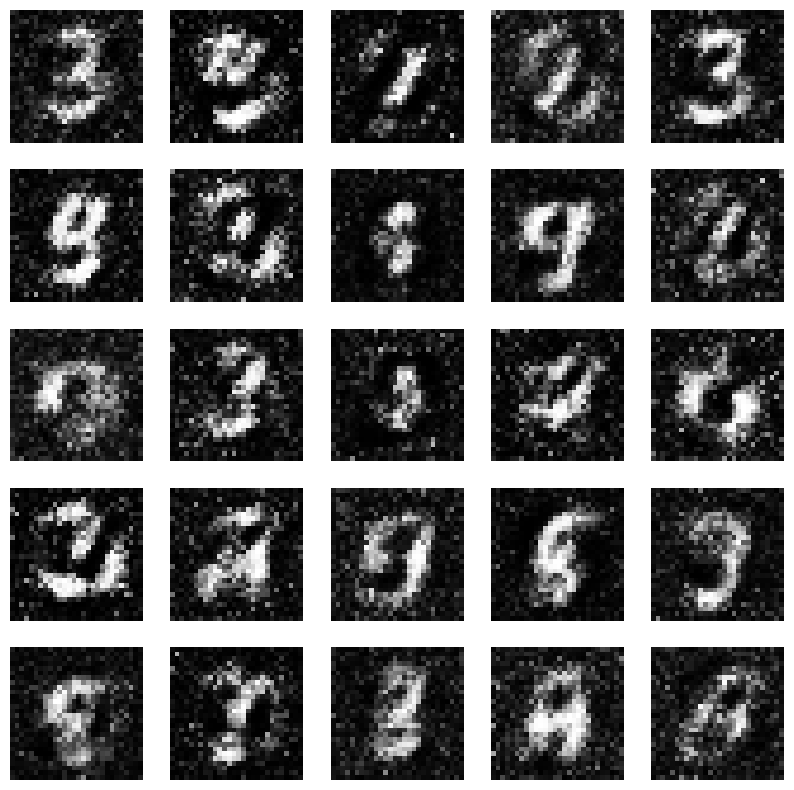

In [22]:
#Evaluate the model using visuals by generating images
def generate_images(generator, num_images):
    noise = np.random.normal(0, 1, (num_images, 100))  # Generate random noise
    generated_images = generator.predict(noise)  # Generate images from the noise

    #Plot the generated images
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.show()

#Generate 25 images
generate_images(generator, 25)

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [27]:
generator.save('/content/drive/My Drive/my_model.h5')